<a href="https://colab.research.google.com/github/RumeysaCeylan/ImageClassification/blob/main/resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# importing libraries

import numpy as np
import matplotlib.pyplot as plt
import os

# Libraries for TensorFlow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers

# Library for Transfer Learning
from tensorflow.keras.applications.resnet50 import ResNet50



from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm

import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb



from keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
IMAGE_SIZE = [224, 224]
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


In [26]:
for layer in resnet.layers:
    layer.trainable = False

In [27]:
folders=glob("/content/drive/MyDrive/archive/Dataset/*")
folders

['/content/drive/MyDrive/archive/Dataset/Very_Mild_Demented',
 '/content/drive/MyDrive/archive/Dataset/Mild_Demented',
 '/content/drive/MyDrive/archive/Dataset/Moderate_Demented',
 '/content/drive/MyDrive/archive/Dataset/Non_Demented']

In [28]:
x = Flatten()(resnet.output)

In [29]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

valid_datagen = ImageDataGenerator(rescale = 1./255)


# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/archive/Dataset',
                                                 target_size = (224, 224),
                                                 batch_size = 128,
                                                 class_mode = 'categorical')



valid_set = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/archive/validation',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 128)
     

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/archive/Test',
                                            target_size = (224, 224),
                                            batch_size = 128,
                                            class_mode = 'categorical')

Found 4030 images belonging to 4 classes.
Found 1103 images belonging to 4 classes.
Found 1281 images belonging to 4 classes.


100%|██████████| 5/5 [00:14<00:00,  2.95s/it]


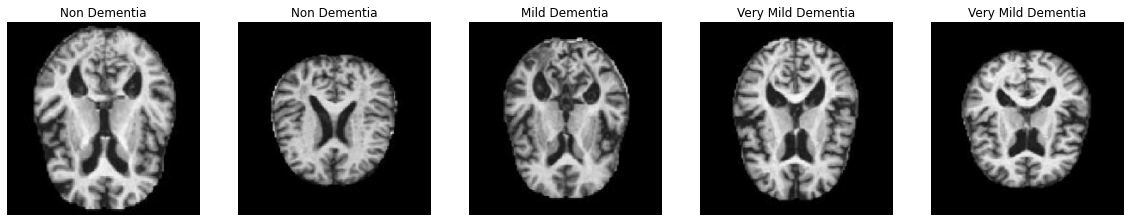

In [30]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(training_set))
    rand2 = np.random.randint(100)
    ax[i].imshow(training_set[rand1][0][rand2])
    ax[i].axis('off')
    a = training_set[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Dementia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [31]:
prediction = Dense(len(folders), activation='softmax')(x)
 
# creating a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [33]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [35]:

import tensorflow 

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)


In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
filepath = '/content/drive/MyDrive/Colab Notebooks/best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [37]:
r = model.fit(
  training_set,
  validation_data=valid_set,
  epochs=20, #10,15,20
  callbacks=callback_list,
  steps_per_epoch=len(training_set),
  validation_steps=len(valid_set)
)


Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 2.8345 - auc: 0.7258
Epoch 1: val_auc improved from -inf to 0.75067, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
32/32 [==============================] - 56s 2s/step - loss: 2.8345 - auc: 0.7258 - val_loss: 2.0072 - val_auc: 0.7507
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 1.2386 - auc: 0.7797
Epoch 2: val_auc improved from 0.75067 to 0.80804, saving model to /content/drive/MyDrive/Colab Notebooks/best_weights.hdf5
32/32 [==============================] - 54s 2s/step - loss: 1.2386 - auc: 0.7797 - val_loss: 1.0379 - val_auc: 0.8080
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 1.0355 - auc: 0.8101
Epoch 3: val_auc did not improve from 0.80804
32/32 [==============================] - 53s 2s/step - loss: 1.0355 - auc: 0.8101 - val_loss: 1.3384 - val_auc: 0.7781
Epoch 4/20
32/32 [==============================] - ETA: 0s - loss: 1.0145 - auc: 0.8

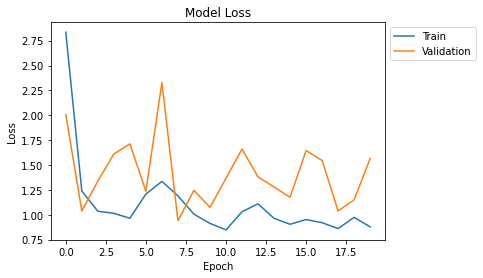

In [38]:
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()
     

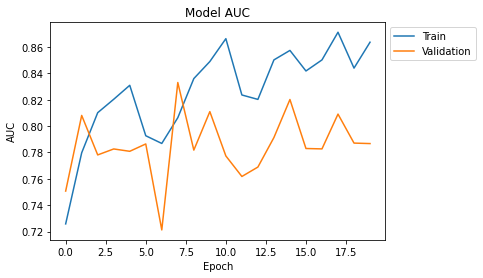

In [39]:
# Summarize history for loss

plt.plot(r.history['auc'])
plt.plot(r.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

1/1 [==============================] - 1s 805ms/step
77.29 % chances are there that the image is Non_Demented


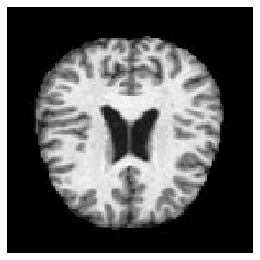

In [40]:
# Test Case 1: Non-Dementia

dic = test_set.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/archive/Test/Non_Demented/non_105.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 28ms/step
77.54 % chances are there that the image is Non_Demented


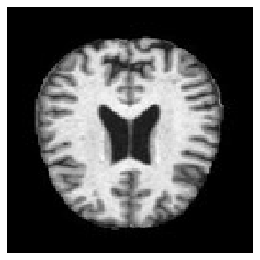

In [41]:
# Test Case 1: mild-Dementia

dic = test_set.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/archive/Test/Very_Mild_Demented/verymild_112.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 32ms/step
76.63 % chances are there that the image is Non_Demented


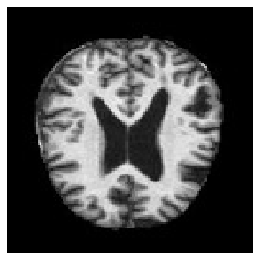

In [42]:
# Test Case 1: mild-Dementia

dic = test_set.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/archive/Test/Non_Demented/non_128.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 31ms/step
57.65 % chances are there that the image is Non_Demented


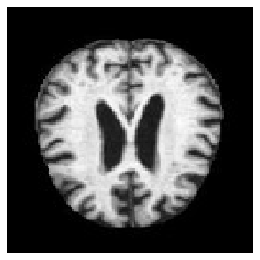

In [43]:
# Test Case 1: mild-Dementia

dic = test_set.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/archive/Test/Mild_Demented/mild_113.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

1/1 [==============================] - 0s 37ms/step
81.28 % chances are there that the image is Non_Demented


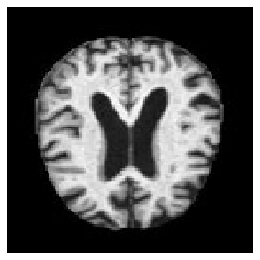

In [44]:
# Test Case 1: mild-Dementia

dic = test_set.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/content/drive/MyDrive/archive/Test/Mild_Demented/mild.jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
#answer = model.predict_classes(img)
answer = np.argmax(model.predict(img), axis=1)
#probability = round(np.max(model.predict_proba(img)*100),2)
probability=round(np.max(model.predict_on_batch(img)*100),2)
print(probability, '% chances are there that the image is',idc[answer[0]])

In [45]:
import tensorflow as tf
from keras.models import load_model
model.save('/content/drive/MyDrive/archive/models/resnet50alzheimer.hdf5')